# **MÓDULO 3, DSA UTN: E-COMMERCE, APLICANDO EDA, RFM Y K-MEANS**

# **EDA (Exploratory Data Analysis):**

El Análisis Exploratorio de Datos (EDA) es un enfoque que se utiliza en ciencia de datos para examinar, resumir y visualizar los datos para obtener información y comprender mejor el conjunto de datos antes de aplicar modelos de aprendizaje automático o realizar análisis más profundos. EDA implica el uso de gráficos, tablas, estadísticas descriptivas y otras técnicas para explorar patrones, tendencias, distribuciones y relaciones en los datos. Este proceso es fundamental para comprender la estructura de los datos, identificar valores atípicos, detectar problemas y tomar decisiones informadas sobre cómo proceder con el análisis.

# CARGAMOS 9 ARCHIVOS DE E-COMMERCE OLIST

In [3]:
#pip install squarify

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,RobustScaler
from ast import And
from yellowbrick.cluster import KElbowVisualizer

import squarify

import warnings
warnings.filterwarnings("ignore")

import datetime as dt

from IPython.display import display, HTML

from google.colab import drive # para cargar dataset
drive.mount("/content/drive")
data_path = "/content/drive/MyDrive/Datasets/E-Commerce/"

customers_df= pd.read_csv(data_path + 'olist_customers_dataset.csv')
geolocation_df= pd.read_csv(data_path + 'olist_geolocation_dataset.csv')
items_df= pd.read_csv(data_path + 'olist_order_items_dataset.csv')
payments_df= pd.read_csv(data_path + 'olist_order_payments_dataset.csv')
reviews_df= pd.read_csv(data_path + 'olist_order_reviews_dataset.csv')
orders_df= pd.read_csv(data_path + 'olist_orders_dataset.csv')
products_df= pd.read_csv(data_path + 'olist_products_dataset.csv')
sellers_df= pd.read_csv(data_path + 'olist_sellers_dataset.csv')

category_translation_df= pd.read_csv(data_path + 'product_category_name_translation.csv') # No esta en Siguiente Diagrama

Mounted at /content/drive


# VISUALIZAMOS EL DIAGRAMA DE DATOS RELACIONAL

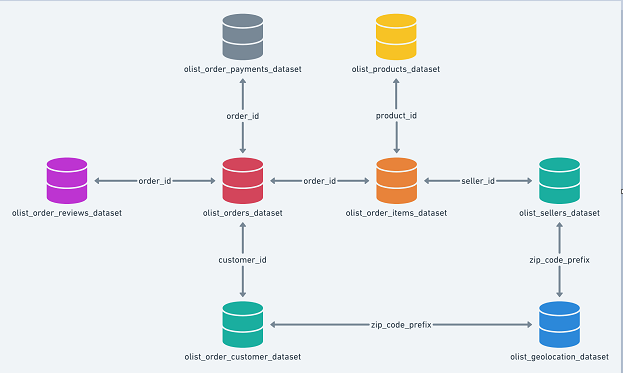

# VISUALIZAMOS RESUMEN DE TODOS LOS DATOS

In [4]:
datasets = [customers_df, geolocation_df, items_df, payments_df, reviews_df, orders_df, products_df, sellers_df, category_translation_df]
titles = ["customers", "geolocation", "items", "payments", "reviews", "orders", "products", "sellers", "category_translation"]
data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['columns'] = [', '.join([col for col, null in data.isnull().sum().items() ]) for data in datasets]
data_summary['total_rows']= [data.shape[0] for data in datasets]
data_summary['total_cols']= [data.shape[1] for data in datasets]
data_summary['total_duplicate']= [len(data[data.duplicated()]) for data in datasets]
data_summary['total_null']= [data.isnull().sum().sum() for data in datasets]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in datasets]
data_summary.style.background_gradient(cmap='YlGnBu')

,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,geolocation,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163,5,261831,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
4,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224,7,0,145903,"review_comment_title, review_comment_message"
5,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441,8,0,4908,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
6,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951,9,0,2448,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0,
8,category_translation,"product_category_name, product_category_name_english",71,2,0,0,


# PREPARACION DE DATOS

In [5]:
# Borramos Nulos y Duplicados

# Originalmente Borramos Nulos y Duplicados, pero al borrar estos registros,
# nos borraba información importante, que nos servia para calculos posteriores (¿ El método de pago afecta el estado del pedido ?)
# por eso se decidio no hacerlo.

'''
for i in datasets:
    i.dropna(inplace=True)

for i in datasets:
    i.drop(i[i.duplicated()].index, axis=0, inplace=True)
'''

'\nfor i in datasets:\n    i.dropna(inplace=True)\n\nfor i in datasets:\n    i.drop(i[i.duplicated()].index, axis=0, inplace=True)\n'

# UNIMOS LOS DATASETS

In [6]:
# Cambiar nombre de Campos para Unificar "zip_code_prefix" de acuerdo al diagrama
customers_df.rename(columns={"customer_zip_code_prefix": "zip_code_prefix"}, inplace=True)
geolocation_df.rename(columns={"geolocation_zip_code_prefix": "zip_code_prefix"}, inplace=True)
#sellers_df.rename(columns={"seller_zip_code_prefix": "zip_code_prefix"}, inplace=True)

# Para hacer la union, hay que tener en cuenta el gráfico
merged_df = orders_df.merge(customers_df, on="customer_id").merge(items_df, on="order_id").merge(products_df, on="product_id").merge(category_translation_df, on="product_category_name").merge(payments_df, on="order_id").merge(sellers_df, on="seller_id").merge(reviews_df, on="order_id")

merged_df.shape

(115609, 40)

In [7]:
merged_df.describe()

,zip_code_prefix,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_installments,payment_value,seller_zip_code_prefix,review_score
count,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000,115608.000000,115608.000000,115608.000000,115608.000000,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000
mean,35061.537597,1.194535,120.619850,20.056880,48.766541,785.808198,2.205373,2113.907697,30.307903,16.638477,23.113167,1.093747,2.946233,172.387379,24515.713958,4.034409
std,29841.671732,0.685926,182.653476,15.836184,10.034187,652.418619,1.717771,3781.754895,16.211108,13.473570,11.755083,0.729849,2.781087,265.873969,27636.640968,1.385584
min,1003.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1.000000,0.000000,0.000000,1001.000000,1.000000
25%,11310.000000,1.000000,39.900000,13.080000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,1.000000,1.000000,60.870000,6429.000000,4.000000
50%,24241.000000,1.000000,74.900000,16.320000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,1.000000,2.000000,108.050000,13660.000000,5.000000
75%,58745.000000,1.000000,134.900000,21.210000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,1.000000,4.000000,189.480000,28605.000000,5.000000
max,99980.000000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,29.000000,24.000000,13664.080000,99730.000000,5.000000


# COMO SE DISTRIBUYE EL SCORE

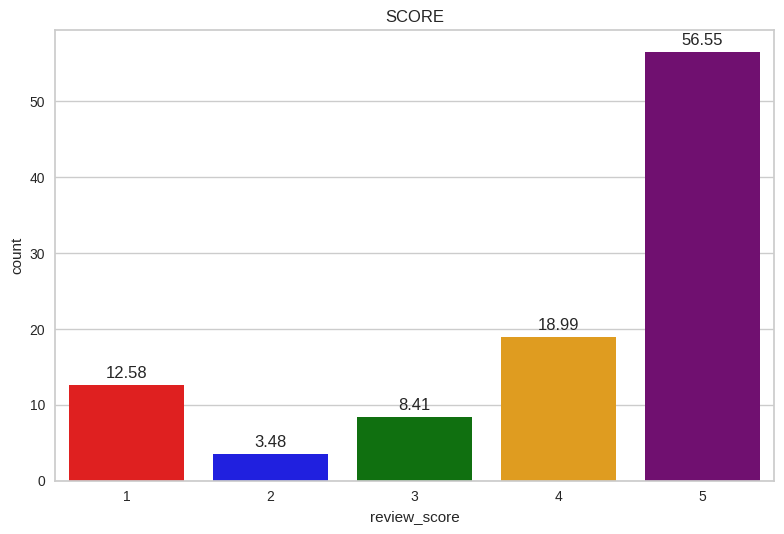

In [8]:
value_counts = merged_df["review_score"].value_counts() / merged_df["review_score"].count() * 100
colores_barras = ['red', 'blue', 'green', 'orange', 'purple']
ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette=colores_barras)

for rect in ax.patches:
    height = rect.get_height()
    if height > 0:
        x = rect.get_x() + rect.get_width() / 2
        y = height
        plt.annotate(f"{height:.2f}", xy=(x, y), xytext=(0, 3), textcoords="offset points", ha="center", va="bottom")

plt.title("SCORE")
plt.xlabel("review_score")
plt.ylabel("count")
plt.ylim(bottom=0)  # Ajustar el rango del eje y para empezar desde 0

plt.tight_layout()
plt.show()

**El 12,58 % le dio una puntuación de 1, el 11,89 % le dio una puntuación de 2 o 3 y el 75,54 % de los clientes le dieron una puntuación de 4 o 5.**

# CONVERTIMOS LOS CAMPOS FECHAS

In [9]:
time_columns= ['order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date','order_delivered_customer_date',
               'order_estimated_delivery_date', 'review_creation_date', 'review_answer_timestamp', 'shipping_limit_date']

merged_df[time_columns]=merged_df[time_columns].apply(pd.to_datetime)

#merged_df.info()

# **RFM Analysis (recency, frequency, monetary):**
Análisis RFM (recencia, frecuencia, valor monetario)

El "RFM" en el análisis RFM representa recencia (Recency), frecuencia (Frequency) y valor monetario (Monetary Value). El análisis RFM es una forma de utilizar datos basados en el comportamiento existente de los clientes para predecir cómo un nuevo cliente es probable que actúe en el futuro. Se construye un modelo RFM utilizando tres factores clave:

Qué tan reciente ha sido la última transacción de un cliente con una marca. Con qué frecuencia han interactuado con una marca. Cuánto dinero han gastado en los productos y servicios de una marca. Un sistema CRM básico puede realizar un seguimiento rudimentario de las tres características fácilmente cuantificables que contribuyen al análisis RFM:

Valor de recencia: Esto se refiere al tiempo transcurrido desde la última interacción del cliente con una marca, que puede incluir su última compra, una visita al sitio web, el uso de una aplicación móvil, un "me gusta" en redes sociales y más. La recencia es una métrica clave porque los clientes que han interactuado con su marca más recientemente tienen más probabilidades de responder a nuevos esfuerzos de marketing.

Valor de frecuencia: Esto se refiere al número de veces que un cliente ha realizado una compra u otra interacción con su marca durante un período de tiempo determinado. La frecuencia es una métrica clave porque muestra qué tan comprometido está un cliente con su marca. Una mayor frecuencia indica un mayor grado de lealtad del cliente.

Valor monetario: Esto se refiere al monto total que un cliente ha gastado comprando productos y servicios de su marca durante un período de tiempo específico. El valor monetario es una métrica clave porque los clientes que más han gastado en el pasado tienen más probabilidades de gastar más en el futuro.

# Vamos a calcular Recency, Frequency, Monetary y eliminamos Outliers

In [10]:
# Para el Análisis se le suman 2 dias al último día
present_day = merged_df['order_purchase_timestamp'].max() + dt.timedelta(days=2)

recency_df= pd.DataFrame(merged_df.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max())
recency_df['Recency']= recency_df['order_purchase_timestamp'].apply(lambda x: (present_day - x).days)

frequency_df = pd.DataFrame(merged_df.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index())
frequency_df.rename(columns={"order_id":"Frequency"}, inplace=True)

monetary_df = merged_df.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary_df.columns = ['customer_unique_id', 'Monetary']

# Unimos los DataSets:
RF_df = recency_df.merge(frequency_df, on='customer_unique_id')
RFM_df = RF_df.merge(monetary_df, on='customer_unique_id').drop(columns='order_purchase_timestamp')


# Revisemos los valores atípicos que caen con límites de +/- 5%:
def num_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.05)
    q3 = df_in[col_name].quantile(0.95)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_df= df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
    return print("Number of outliers in {} column: ".format(col_name), len(outliers_df)), print("Indexes: ", outliers_df.index)

# Eliminemos los valores atípicos que caen con límites de +/- 5%, excepto las columnas de frecuencia:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.05)
    q3 = df_in[col_name].quantile(0.95)
    iqr = q3 - q1
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    index_outliers = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)].index
    df_in.drop(index_outliers, axis=0, inplace=True)  # Remove outliers from the original DataFrame
    print("Outliers in the {} column have been removed".format(col_name))
    return df_in

for i in ["Recency", "Frequency", "Monetary"]:
    num_outlier(RFM_df, i)
    print("*"*40)

RFM_df1= RFM_df.copy()

print("")

for i in ["Recency", "Monetary"]:
    remove_outlier(RFM_df, i)
    print("*" * 40)

RFM_df2= RFM_df.copy()


Number of outliers in Recency column:  0
Indexes:  Int64Index([], dtype='int64')
****************************************
Number of outliers in Frequency column:  2807
Indexes:  Int64Index([  104,   120,   140,   243,   305,   404,   419,   428,   438,
              467,
            ...
            92799, 92856, 92956, 92960, 93027, 93071, 93123, 93228, 93244,
            93352],
           dtype='int64', length=2807)
****************************************
Number of outliers in Monetary column:  1043
Indexes:  Int64Index([  221,   256,   288,   416,   539,   571,   608,   614,   704,
              749,
            ...
            93037, 93042, 93067, 93119, 93166, 93218, 93238, 93302, 93384,
            93391],
           dtype='int64', length=1043)
****************************************

Outliers in the Recency column have been removed
****************************************
Outliers in the Monetary column have been removed
****************************************


In [11]:
RFM_df1.shape

(93396, 4)

In [12]:
RFM_df2.shape

(92353, 4)

# Visualizamos Recency, Frequency, Monetary con y sin Outliers

In [13]:
df1 = pd.DataFrame(RFM_df1.head(10))
df2 = pd.DataFrame(RFM_df1.describe())
df3 = pd.DataFrame(RFM_df2.head(10))
df4 = pd.DataFrame(RFM_df2.describe())

# HTML para mostrar los DataFrames en una tabla con dos columnas
html_code = f"""
<table style="width:100%">
  <tr>
    <td style="width:50%">
    <h3>Visualizamos Recency, Frequency, Monetary con Outliers</h3>
      {df1.to_html()}
    </td>
    <td style="width:50%">
    <h3>describe()</h3>
      {df2.to_html()}
    </td>
  </tr>
</table>
<br><br>
<table style="width:100%">
  <tr>
    <td style="width:50%">
    <h3>Visualizamos Recency, Frequency, Monetary sin Outliers</h3>
      {df3.to_html()}
    </td>
    <td style="width:50%">
    <h3>describe()</h3>
      {df4.to_html()}
    </td>
  </tr>
</table>
"""
display(HTML(html_code))

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,27.19
2,0000f46a3911fa3c0805444483337064,543,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,294,1,196.89
5,0004bd2a26a76fe21f786e4fbd80607f,152,1,166.98
6,00050ab1314c0e55a6ca13cf7181fecf,137,1,35.38
7,00053a61a98854899e70ed204dd4bafe,188,1,838.36
8,0005e1862207bf6ccc02e4228effd9a0,549,1,150.12
9,0005ef4cd20d2893f0d9fbd94d3c0d97,176,1,129.76


# Graficamos Recency, Frecuency, Monetary con y sin Outliers

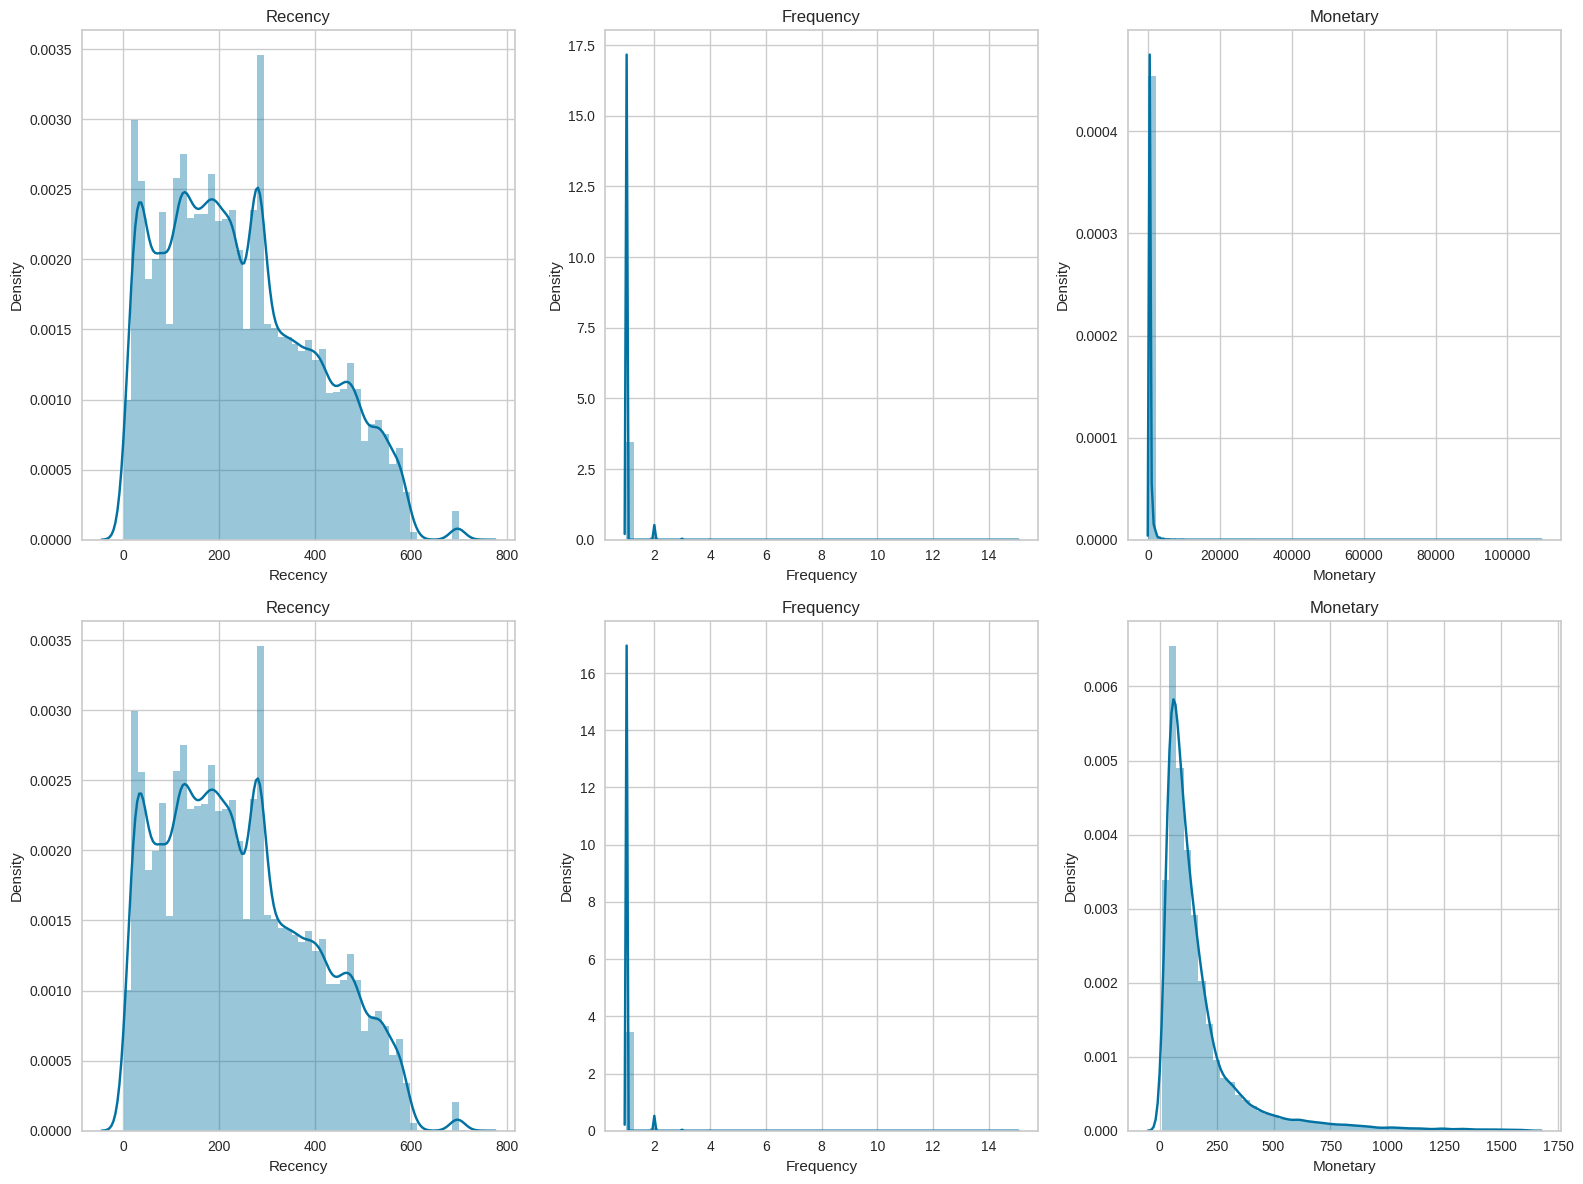

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(16, 12))

# Gráfico 1: Recency
sns.distplot(RFM_df1['Recency'], ax=axs[0, 0])
axs[0, 0].set_title('Recency')

# Gráfico 2: Frequency
sns.distplot(RFM_df1['Frequency'], ax=axs[0, 1])
axs[0, 1].set_title('Frequency')

# Gráfico 3: Monetary
sns.distplot(RFM_df1['Monetary'], ax=axs[0, 2])
axs[0, 2].set_title('Monetary')

# Gráfico 4: Recency
sns.distplot(RFM_df2['Recency'], ax=axs[1, 0])
axs[1, 0].set_title('Recency')

# Gráfico 5: Frequency
sns.distplot(RFM_df2['Frequency'], ax=axs[1, 1])
axs[1, 1].set_title('Frequency')

# Gráfico 6: Monetary
sns.distplot(RFM_df2['Monetary'], ax=axs[1, 2])
axs[1, 2].set_title('Monetary')

plt.tight_layout()
plt.show()


# Visualizamos Boxplot de Recency, Frequency, Monetary con y sin Outliers

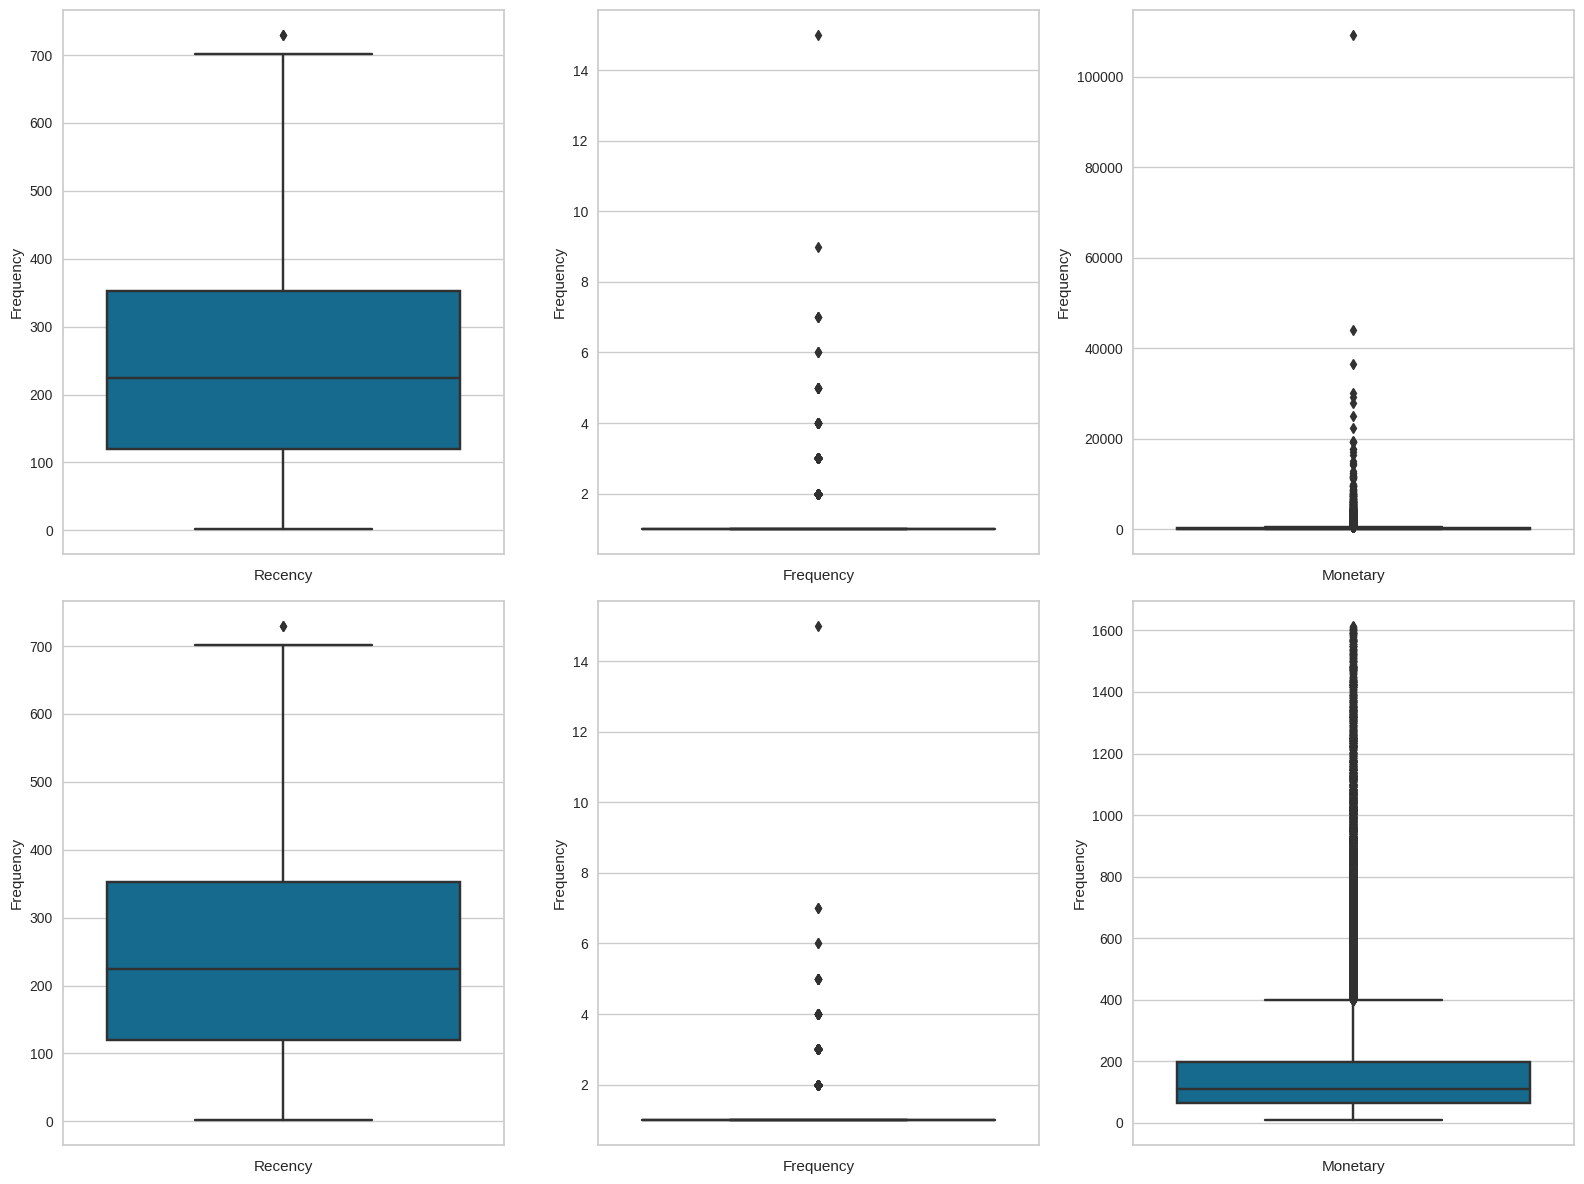

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(16, 12))

# Gráfico 1: Recency
sns.boxplot(y=RFM_df1['Recency'], ax=axs[0, 0])
axs[0, 0].set(xlabel='Recency', ylabel='Frequency')

# Gráfico 2: Frequency
sns.boxplot(y=RFM_df1['Frequency'], ax=axs[0, 1])
axs[0, 1].set(xlabel='Frequency', ylabel='Frequency')

# Gráfico 3: Monetary
sns.boxplot(y=RFM_df1['Monetary'], ax=axs[0, 2])
axs[0, 2].set(xlabel='Monetary', ylabel='Frequency')

# Gráfico 4: Recency
sns.boxplot(y=RFM_df2['Recency'], ax=axs[1, 0])
axs[1, 0].set(xlabel='Recency', ylabel='Frequency')

# Gráfico 5: Frequency
sns.boxplot(y=RFM_df2['Frequency'], ax=axs[1, 1])
axs[1, 1].set(xlabel='Frequency', ylabel='Frequency')

# Gráfico 6: Monetary
sns.boxplot(y=RFM_df2['Monetary'], ax=axs[1, 2])
axs[1, 2].set(xlabel='Monetary', ylabel='Frequency')

plt.tight_layout()
plt.show()


# Top 10, mejores clientes por total pagado, estados por número de pedidos, ciudades por generación de ingresos

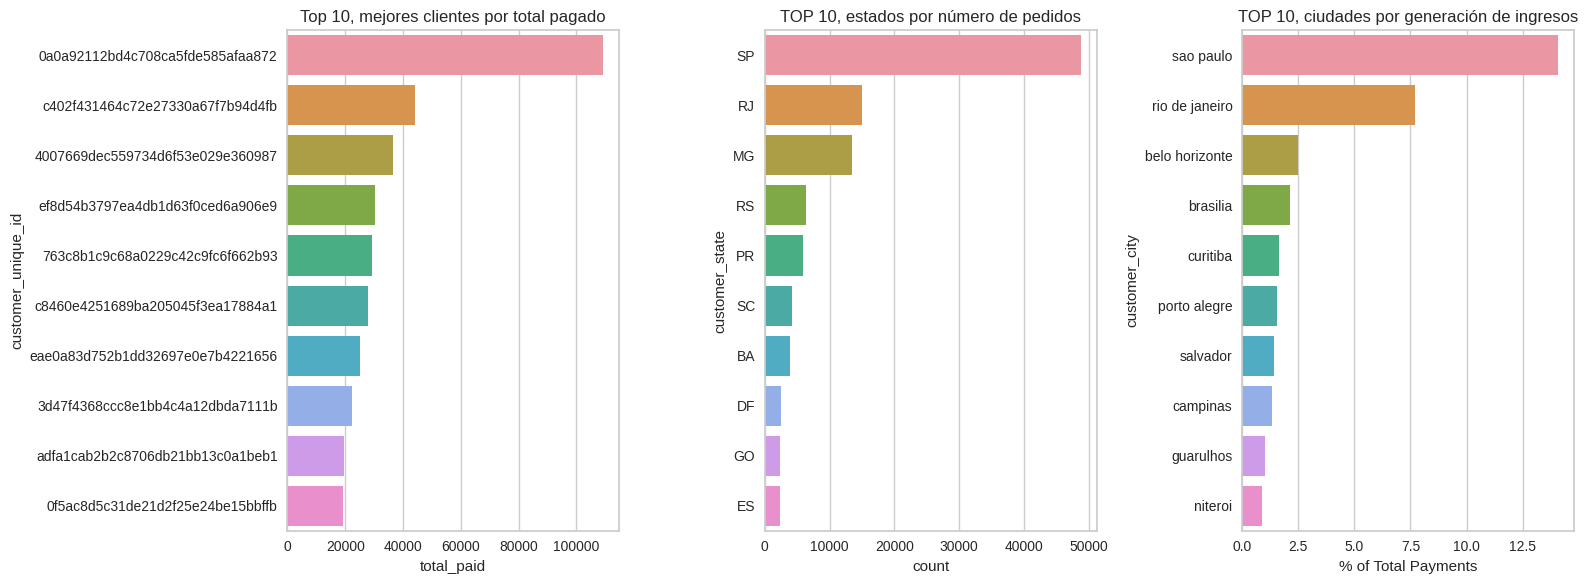

In [16]:
# Customers with highest cum orders (in payments)
top_customers = merged_df.groupby("customer_unique_id")["payment_value"].sum().reset_index().sort_values("payment_value", ascending=False)
top_customers.rename(columns={"payment_value":"total_paid"}, inplace=True)

# Crear el array de subplots de 1 fila y 3 columnas
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# Gráfico 1: Top 10, mejores clientes por total pagado
top_customers.rename(columns={"payment_value" : "total_paid"}, inplace=True)
ax = sns.barplot(x="total_paid", y="customer_unique_id", data=top_customers[:10], ax=axs[0])
ax.set_title("Top 10, mejores clientes por total pagado")

# Gráfico 2: TOP 10, estados por número de pedidos
top_orders_cities = merged_df.groupby("customer_state")["order_id"].count().reset_index().sort_values("order_id", ascending=False)
top_orders_cities.rename(columns={"order_id":"count"}, inplace=True)
ax = sns.barplot(x="count", y="customer_state", data=top_orders_cities[:10], ax=axs[1])
ax.set_title("TOP 10, estados por número de pedidos")

# Gráfico 3: TOP 10, ciudades por generación de ingresos
top_ordersbyvalue_cities = merged_df.groupby("customer_city")["payment_value"].sum().reset_index().sort_values("payment_value", ascending=False)
top_ordersbyvalue_cities["% of Total Payments"] = (top_ordersbyvalue_cities["payment_value"] / top_ordersbyvalue_cities["payment_value"].sum()) * 100
top_ordersbyvalue_cities["Cum % of Total Payments"] = top_ordersbyvalue_cities["% of Total Payments"].cumsum()
ax = sns.barplot(x="% of Total Payments", y="customer_city", data=top_ordersbyvalue_cities[:10], ax=axs[2])
ax.set_title("TOP 10, ciudades por generación de ingresos")

plt.tight_layout()
plt.show()


# Proporción de clientes que generan la mayor parte de los ingresos y Contribución a las Ventas por número de ciudades:

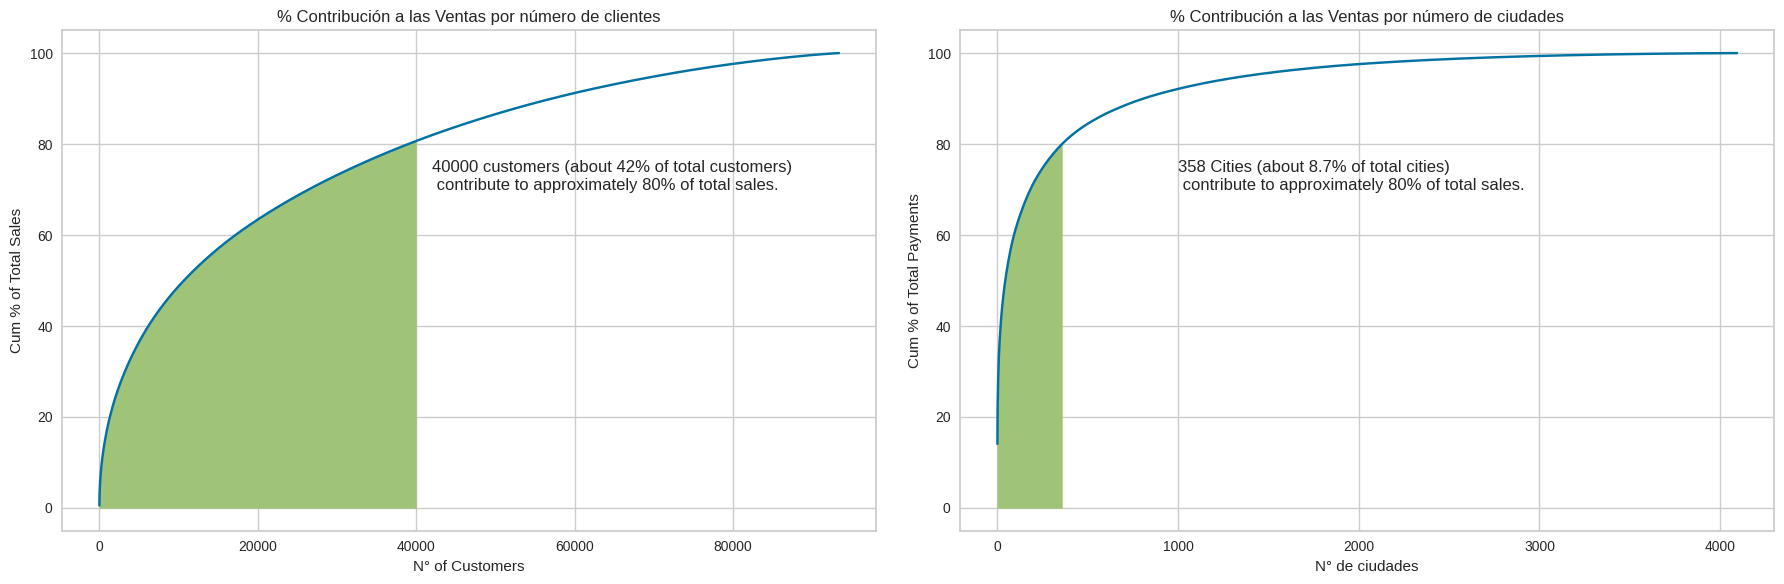

In [17]:

# Plot 1 - Customer Contribution to Sales
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
top_customers["% of Total Sales"] = (top_customers["total_paid"] / top_customers["total_paid"].sum()) * 100
top_customers["Cum % of Total Sales"] = top_customers["% of Total Sales"].cumsum()
ax = sns.lineplot(x=range(1,len(top_customers)+1), y="Cum % of Total Sales", data=top_customers)
ax.set_xlabel("N° of Customers")
ax.set_title("% Contribución a las Ventas por número de clientes")
a = np.arange(1, len(top_customers)+1)
b = top_customers["Cum % of Total Sales"]
plt.fill_between(a, b, 0, where=(a >= 0) & (a <= 40000), color='g')
ax.text(42000, 70, "40000 customers (about 42% of total customers)\n contribute to approximately 80% of total sales.", fontsize=12)

# Orders by Value in Cities
plt.subplot(1, 2, 2)
ax = sns.lineplot(x=range(1, len(top_ordersbyvalue_cities) + 1), y="Cum % of Total Payments", data=top_ordersbyvalue_cities)
ax.set_xlabel("N° de ciudades")
ax.set_title("% Contribución a las Ventas por número de ciudades")
a = np.arange(1, len(top_ordersbyvalue_cities) + 1)
b = top_ordersbyvalue_cities["Cum % of Total Payments"]
plt.fill_between(a, b, 0, where=(a >= 0) & (a <= 358), color='g')
ax.text(1000, 70, "358 Cities (about 8.7% of total cities)\n contribute to approximately 80% of total sales.", fontsize=12)

plt.tight_layout()
plt.show()



In [18]:
print("Números de ciudades que contrubuyen al 80% del total de las ventas:",
      len(top_ordersbyvalue_cities[top_ordersbyvalue_cities["Cum % of Total Payments"] <= 80]),
      "o en %:",
      (len(top_ordersbyvalue_cities[top_ordersbyvalue_cities["Cum % of Total Payments"] <= 80]) / len(top_ordersbyvalue_cities)) * 100)

Números de ciudades que contrubuyen al 80% del total de las ventas: 358 o en %: 8.746640605912534


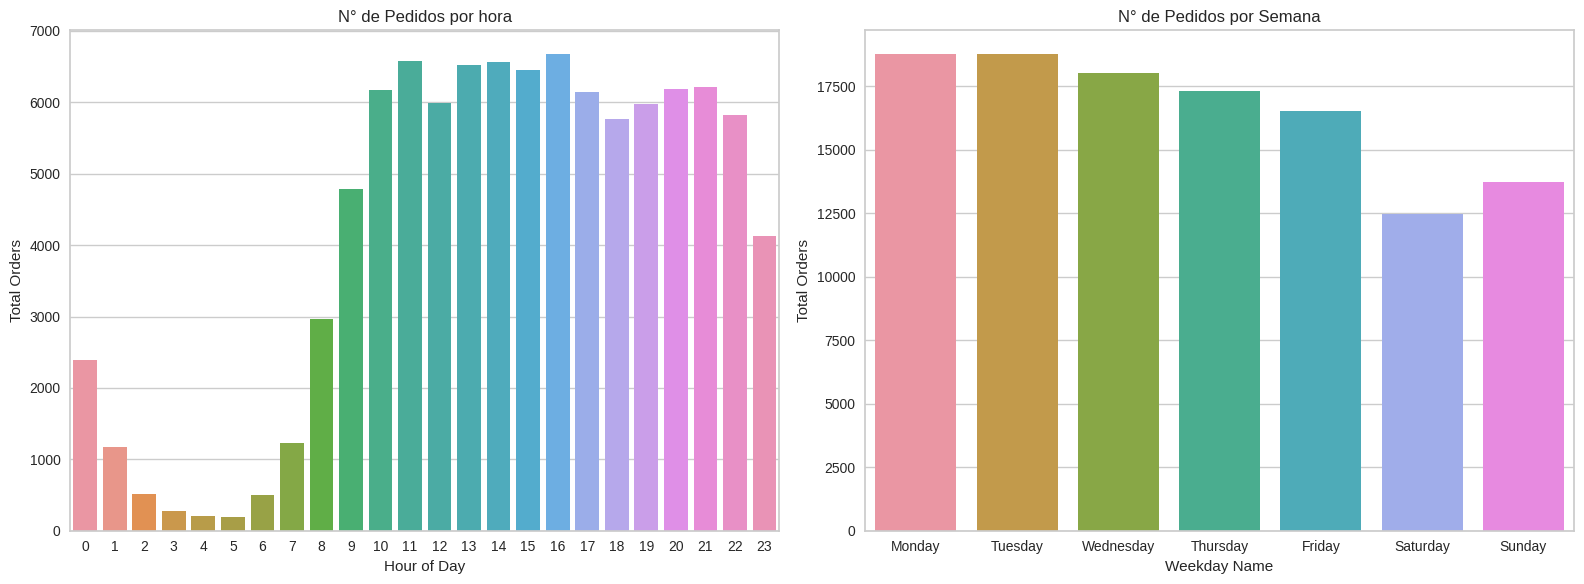

In [19]:
# Convertir a datetime una sola vez
orders_df["order_purchase_timestamp"] = pd.to_datetime(orders_df["order_purchase_timestamp"])

# Obtener el conteo de pedidos por hora
orderbyhour = orders_df["order_purchase_timestamp"].dt.hour.value_counts().reset_index()
orderbyhour.rename(columns={"index": "Hour of Day", "order_purchase_timestamp": "Total Orders"}, inplace=True)
orderbyhour.sort_values(by="Hour of Day", ascending=False, inplace=True)

# Convertir a datetime una sola vez
merged_df["order_purchase_timestamp"] = pd.to_datetime(merged_df["order_purchase_timestamp"])

# Obtener el conteo de pedidos por día de la semana
orderbydow = merged_df["order_purchase_timestamp"].dt.day_name().value_counts().reset_index()
orderbydow.rename(columns={"index": "Weekday Name", "order_purchase_timestamp": "Total Orders"}, inplace=True)

# Ordenar los días de la semana en orden cronológico
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
orderbydow["Weekday Name"] = pd.Categorical(orderbydow["Weekday Name"], categories=weekday_order, ordered=True)

# Crear la grilla de 1 fila por 2 columnas
plt.figure(figsize=(16, 6))

# Primer subplot (1, 2, 1)
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x="Hour of Day", y="Total Orders", data=orderbyhour)
ax1.set_title("N° de Pedidos por hora")

# Segundo subplot (1, 2, 2)
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x="Weekday Name", y="Total Orders", data=orderbydow)
ax2.set_title("N° de Pedidos por Semana")

plt.tight_layout()  # Ajustar el diseño para que los gráficos no se superpongan
plt.show()


In [20]:
orders_df.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [21]:
payments_df.payment_type.value_counts()


credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

In [22]:
# Best and worst rated products
#plt.figure(figsize=(12,12))
reviewsocres = merged_df.groupby("product_category_name_english")["review_score"].agg(["mean", "count"]).sort_values(by="mean",ascending=False)
bestrated = reviewsocres[reviewsocres["count"]>=30][:10]

# Bottom 10 Products by review socres
worstrated = reviewsocres[reviewsocres["count"]>=30].sort_values(by='mean')[:10]

# For example: does paying cash increase order cancelation
cashvscancel = pd.crosstab(merged_df["payment_type"], merged_df["order_status"])
cashvscancel = cashvscancel[["canceled", "delivered"]]
cashvscancel["% Canceled"] = (cashvscancel["canceled"] / cashvscancel["delivered"] ) * 100
cashvscancel["Avg Cancelation Rate"] = (len(merged_df[merged_df["order_status"] == "canceled"]) / len(merged_df[merged_df["order_status"] == "delivered"])) * 100

merged_df["TimeToDeliveryinHours"] = (merged_df["order_delivered_customer_date"] - merged_df["order_purchase_timestamp"])
merged_df["TimeToDeliveryinHours"] = merged_df["TimeToDeliveryinHours"].apply(lambda x: x.total_seconds())
merged_df["TimeToDeliveryinHours"] = round((merged_df["TimeToDeliveryinHours"] / 3600) / 24, 2)
merged_df.rename(columns={"TimeToDeliveryinHours" : "TimeToDeliveryinDays"}, inplace=True)

df1 = pd.DataFrame(bestrated)
df2 = pd.DataFrame(worstrated)
df3 = pd.DataFrame(cashvscancel)
df4 = pd.DataFrame(merged_df["TimeToDeliveryinDays"].describe())

# HTML para mostrar los DataFrames en una tabla con dos columnas
html_code = f"""
<table style="width:100%">
  <tr>
    <td style="width:50%">
    <h3>¿ Cómo se clasifican los productos ?</h3>
      {df1.to_html()}
    </td>
    <td style="width:50%">
    <h3>Los 10 productos inferiores por revisión</h3>
      {df2.to_html()}
    </td>
  </tr>
</table>
<br><br>
<table style="width:100%">
  <tr>
    <td style="width:50%">
    <h3>¿ El método de pago afecta el estado del pedido ?</h3>
      {df3.to_html()}
      Podemos ver que la tasa de cancelación es prácticamente la misma en todos los métodos de pago. Pero notamos una ligera desviación por encima de la media para credit_card.
    </td>
    <td style="width:50%">
    <h3>¿ Existe alguna relación entre el tiempo de entrega y los puntajes de revisión ?</h3>
      {df4.to_html()}
      El tiempo de entrega es bastante alto en promedio (12,44 días) con una mediana de (10,19 días). Notamos un valor atípico extremo de 208,35 días.
    </td>
  </tr>
</table>
"""
display(HTML(html_code))


,mean,count
product_category_name_english,,
books_general_interest,4.438503,561
books_imported,4.419355,62
flowers,4.419355,31
costruction_tools_tools,4.415842,101
books_technical,4.375465,269
food_drink,4.324138,290
small_appliances_home_oven_and_coffee,4.320513,78
luggage_accessories,4.295945,1159
fashion_sport,4.258065,31


# Visualizamos Boxplot de pedidos que tardaron mucho en ser entregados por alguna razón.

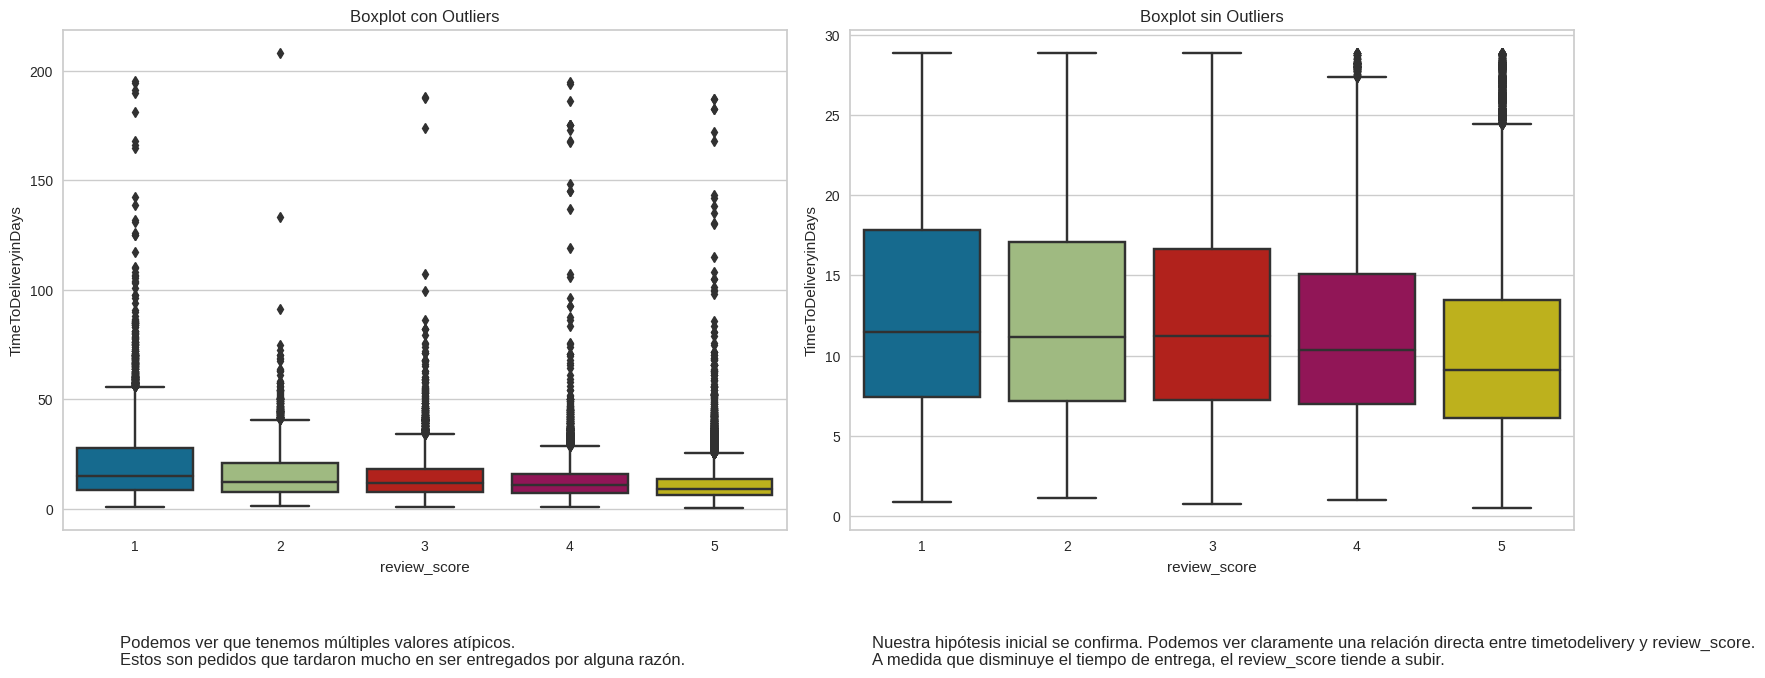

In [23]:
plt.figure(figsize=(16, 6))

# Primer subplot (1, 2, 1)
plt.subplot(1, 2, 1)
sns.boxplot(x="review_score", y="TimeToDeliveryinDays", data=merged_df)
plt.title("Boxplot con Outliers")

# Outliers removal
q_high = merged_df["TimeToDeliveryinDays"].quantile(0.95)
data_no_outliers = merged_df[merged_df["TimeToDeliveryinDays"] < q_high]

# Segundo subplot (1, 2, 2)
plt.subplot(1, 2, 2)
sns.boxplot(x="review_score", y="TimeToDeliveryinDays", data=data_no_outliers)
plt.title("Boxplot sin Outliers")

# Agregar el texto debajo del primer subplot
plt.figtext(0.08, -0.1, "Podemos ver que tenemos múltiples valores atípicos.\nEstos son pedidos que tardaron mucho en ser entregados por alguna razón.",
            fontsize=12, ha='left', va='center')

# Agregar el texto debajo del segundo subplot
plt.figtext(0.55, -0.1, "Nuestra hipótesis inicial se confirma. Podemos ver claramente una relación directa entre timetodelivery y review_score.\nA medida que disminuye el tiempo de entrega, el review_score tiende a subir.",
            fontsize=12, ha='left', va='center')

plt.tight_layout()  # Ajustar el diseño para que los gráficos no se superpongan
plt.show()


# ¿Cuáles son las ciudades de los vendedores con el tiempo de entrega más bajo/más alto?

In [24]:
# Let's see sellers with best deliverytime
sellersdeliverytime = merged_df.groupby("seller_city")["TimeToDeliveryinDays"].agg(["min", "max", "mean", "std", "count" ]).dropna().sort_values("mean").reset_index()
# Filter for sellers with 30 or more orders in their history
sellersdeliverytime = sellersdeliverytime[sellersdeliverytime["count"]>=30]

slowestdeliverysellers = sellersdeliverytime.sort_values("mean", ascending=False)[:10]
fastestdeliverysellers = sellersdeliverytime[:10]

df1 = pd.DataFrame(slowestdeliverysellers)
df2 = pd.DataFrame(fastestdeliverysellers)

# HTML para mostrar los DataFrames en una tabla con dos columnas
html_code = f"""
<table style="width:100%">
  <tr>
    <td style="width:50%">
    <h3>Más Bajo</h3>
      {df1.to_html()}
    </td>
    <td style="width:50%">
    <h3>Más Alto</h3>
      {df2.to_html()}
    </td>
  </tr>
</table>
"""
display(HTML(html_code))

,seller_city,min,max,mean,std,count
515,mombuca,6.03,88.24,22.921515,17.782976,33
509,itaquaquecetuba,1.61,194.85,21.838281,12.911572,1734
507,congonhal,4.31,60.82,21.590463,12.736508,108
504,balneario camboriu,3.25,79.36,20.641613,17.449918,31
503,tubarao,6.01,81.33,19.930286,20.308568,35
499,foz do iguacu,2.98,92.78,19.490833,17.240529,192
492,bombinhas,5.13,68.10,18.875761,9.758911,92
491,criciuma,3.73,71.16,18.396000,15.760557,35
488,claudio,5.73,48.63,18.171318,8.158321,129
482,caucaia,3.14,138.88,17.841471,23.052995,34


# Graficar la relación entre el tiempo promedio de entrega (mean) y el promedio de review_score

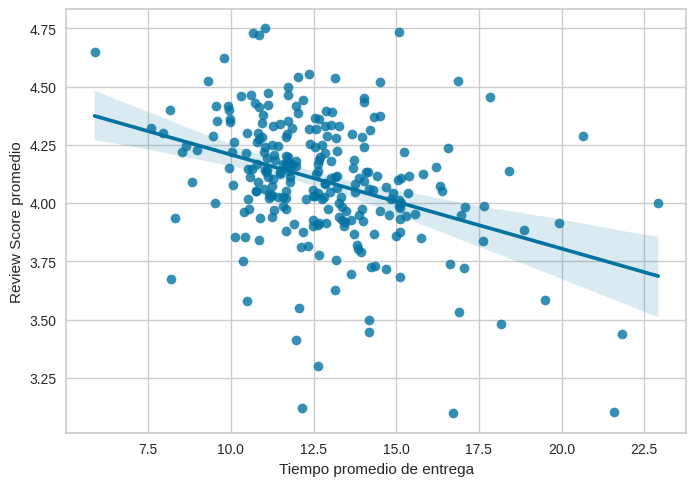

In [25]:

# Calcular el promedio de review_score por seller_city y eliminar filas con valores faltantes
avg_review_score_seller = merged_df.groupby("seller_city")["review_score"].mean().dropna()

# Calcular el tiempo promedio de entrega por seller_city
sellerPerf = sellersdeliverytime.join(avg_review_score_seller, on="seller_city", rsuffix="_review_score")

# Graficar la relación entre el tiempo promedio de entrega (mean) y el promedio de review_score
ax = sns.regplot(x="mean", y="review_score", data=sellerPerf)
ax.set_xlabel("Tiempo promedio de entrega")
ax.set_ylabel("Review Score promedio")
plt.show()


**Podemos ver claramente que existe una relación negativa moderada entre el tiempo que tardan los vendedores en entregar sus pedidos y la revisión que reciben.**

# Estados con el tiempo de entrega más alto/más bajo

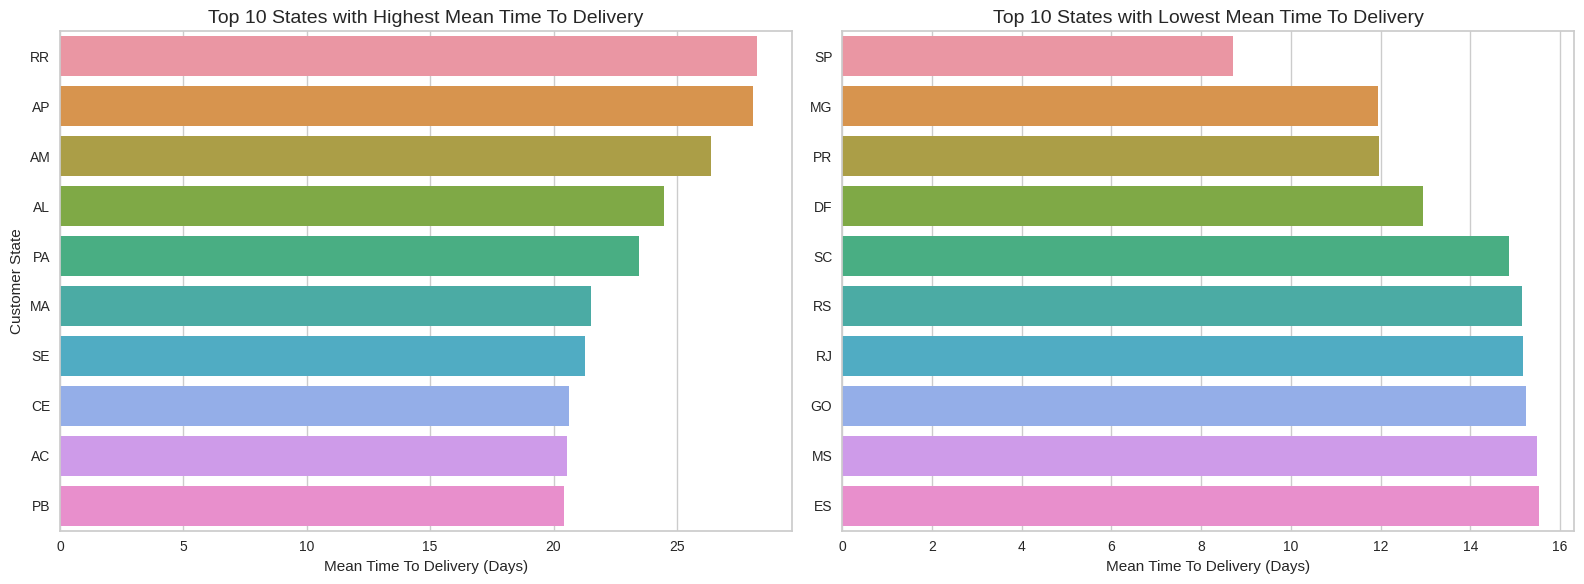

In [26]:

# Calculate the mean TimeToDeliveryinDays for each customer_state and select the top 10 states with highest mean
highestTTDstates = merged_df.groupby("customer_state")["TimeToDeliveryinDays"].mean().dropna().nlargest(10).reset_index()

# Calculate the mean TimeToDeliveryinDays for each customer_state and select the top 10 states with lowest mean
lowestTTDstates = merged_df.groupby("customer_state")["TimeToDeliveryinDays"].mean().dropna().nsmallest(10).reset_index()

# Create the grid of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the barplot for highestTTDstates in the first subplot
sns.barplot(y="customer_state", x="TimeToDeliveryinDays", data=highestTTDstates, ax=axs[0])
axs[0].set_xlabel("Mean Time To Delivery (Days)")
axs[0].set_ylabel("Customer State")
axs[0].set_title("Top 10 States with Highest Mean Time To Delivery", fontsize=14)

# Plot the barplot for lowestTTDstates in the second subplot
sns.barplot(y="customer_state", x="TimeToDeliveryinDays", data=lowestTTDstates, ax=axs[1])
axs[1].set_xlabel("Mean Time To Delivery (Days)")
axs[1].set_ylabel("")  # Remove the y-label to avoid duplication
axs[1].set_title("Top 10 States with Lowest Mean Time To Delivery", fontsize=14)

plt.tight_layout()
plt.show()


# ¿Cómo varían el tiempo de entrega promedio y la calificación promedio de las reseñas a lo largo del tiempo?

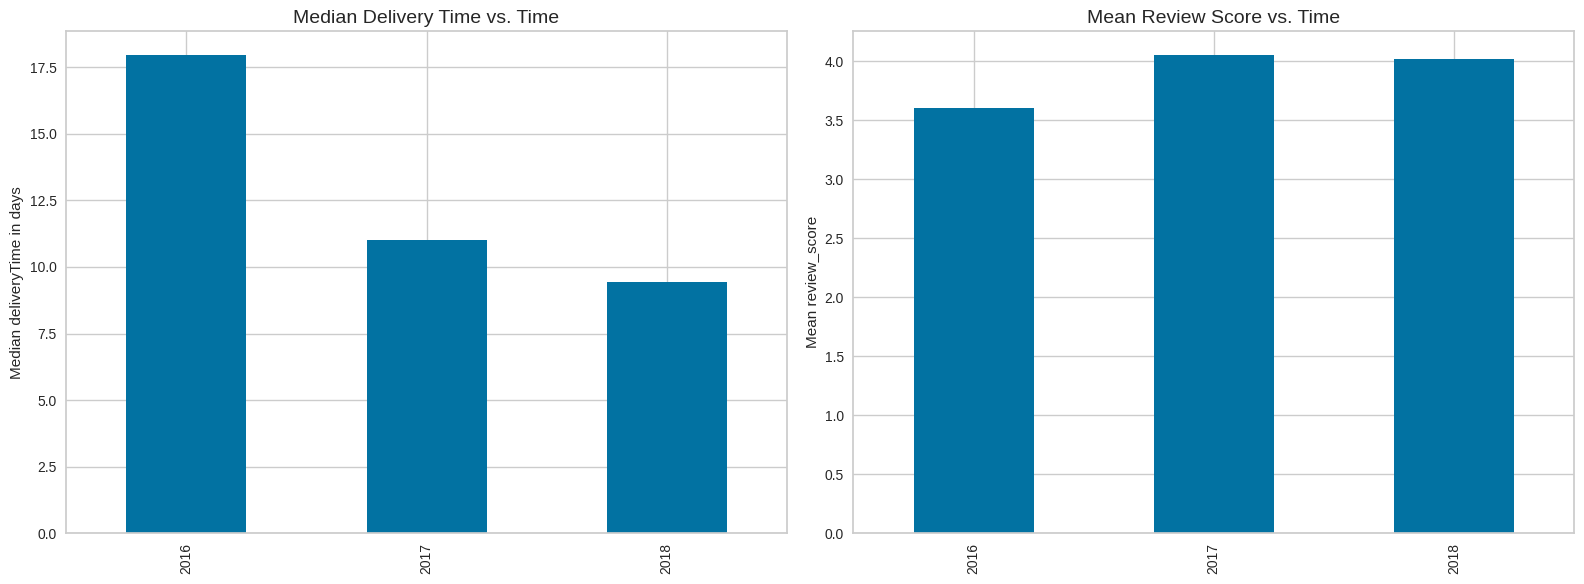

In [27]:

# Calculate median delivery time for each year
deliverytimevstime = merged_df.groupby(merged_df["order_purchase_timestamp"].dt.year)["TimeToDeliveryinDays"].median().dropna()

# Calculate mean review score for each year
scorevstime = merged_df.groupby(merged_df["order_purchase_timestamp"].dt.year)["review_score"].mean().dropna()

# Create the grid of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the bar plot for delivery time vs. time in the first subplot
deliverytimevstime.plot(kind="bar", ax=axs[0])
axs[0].set_xlabel("")
axs[0].set_ylabel("Median deliveryTime in days")
axs[0].set_title("Median Delivery Time vs. Time", fontsize=14)

# Plot the bar plot for review score vs. time in the second subplot
scorevstime.plot(kind="bar", ax=axs[1])
axs[1].set_xlabel("")
axs[1].set_ylabel("Mean review_score")
axs[1].set_title("Mean Review Score vs. Time", fontsize=14)

plt.tight_layout()
plt.show()



Podemos ver que la empresa hizo una mejora significativa en el tiempo de entrega. En 2016, el tiempo medio de entrega superaba los 17 días, mientras que en 2017 se redujo a unos 12 y a unos 9 días en 2018.

Los clientes están dando mejores puntuaciones en 2017 y 2018 que en 2016.

# ¿Cuáles son las categorías de producto más vendidas?

In [28]:
top_categ_by_revenue = merged_df.groupby("product_category_name_english").agg({'order_id':'nunique','payment_value':'sum'}).sort_values("payment_value", ascending=False)[:10]
top_categ_by_revenue.rename(columns={"order_id":"NumOfOrders", "payment_value":"Revenues"}, inplace=True)

top_categ_by_revenue

,NumOfOrders,Revenues
product_category_name_english,,
bed_bath_table,9313,1725465.67
health_beauty,8770,1646292.53
computers_accessories,6649,1592611.66
furniture_decor,6398,1427214.01
watches_gifts,5576,1420682.17
sports_leisure,7669,1390581.87
housewares,5843,1091709.15
garden_tools,3496,834757.45
auto,3877,802254.74


# **K-MEANS:**
K-means es un popular algoritmo de aprendizaje automático no supervisado utilizado para agrupar datos en clústeres basados en características similares. El algoritmo busca dividir los datos en K grupos, donde K es un número predeterminado. Cada clúster tiene un centroide que representa el valor medio de todas las instancias en ese clúster.

El proceso del algoritmo K-means implica los siguientes pasos:

Inicialización: Se eligen K puntos iniciales como centroides.
Asignación: Se asignan todas las instancias a su centroide más cercano.
Actualización: Se recalcula el centroide de cada clúster en función de las instancias asignadas a él.
Repetición: Los pasos de asignación y actualización se repiten hasta que los centroides convergen y los clústeres no cambian significativamente.
K-means es ampliamente utilizado en segmentación de clientes, análisis de datos y otras tareas de agrupamiento en las que se desea dividir los datos en grupos homogéneos con características similares.

In [29]:
# Función para aplicar el escalado estándar y robusto a una columna numerica
def apply_scaler(df, column_name, option):
    if option not in ["Standard", "Robust"]:
        raise ValueError("Invalid option. Choose 'Standard' or 'Robust'.")
    scaler = StandardScaler() if option == "Standard" else RobustScaler()
    df_scaled = df.copy()
    df_scaled[column_name] = scaler.fit_transform(df_scaled[[column_name]])
    return df_scaled

RFM_df2 = apply_scaler(RFM_df2, 'Recency', 'Standard')
RFM_df2 = apply_scaler(RFM_df2, 'Frequency', 'Standard')
RFM_df2 = apply_scaler(RFM_df2, 'Monetary', 'Standard')

RFM_df2_scaled = RFM_df2[['Recency','Frequency','Monetary']]

RFM_df2_scaled.head()


,Recency,Frequency,Monetary
0,-0.827797,-0.159821,-0.173045
1,-0.808204,-0.159821,-0.735810
2,1.954376,-0.159821,-0.446210
3,0.543697,-0.159821,-0.655205
4,0.328176,-0.159821,0.096735


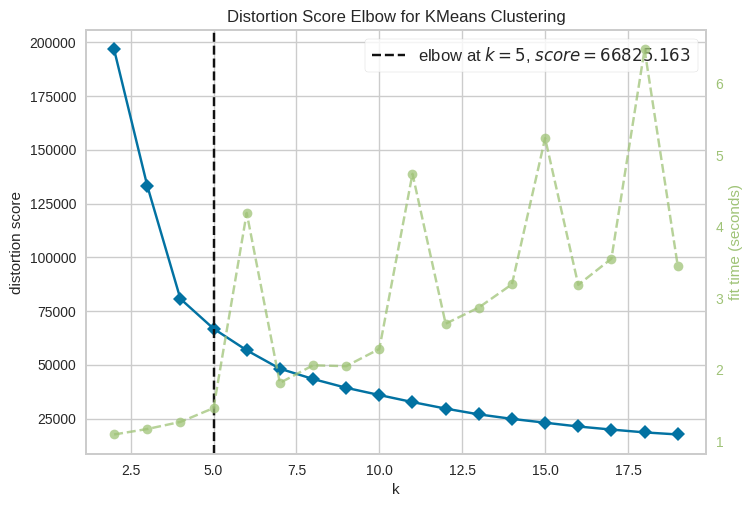

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
k_means = KMeans()
elbow = KElbowVisualizer(k_means, k=(2, 20))
elbow.fit(RFM_df2_scaled)
elbow.show()

**Se encontró que el valor K óptimo para Elbow era 5.**

In [32]:
kmeans= KMeans(n_clusters=5)
kmeans.fit(RFM_df2_scaled)

KMeans(n_clusters=5)

In [33]:
RFM_df2_scaled['Cluster']= kmeans.labels_
RFM_df2_scaled.head()

,Recency,Frequency,Monetary,Cluster
0,-0.827797,-0.159821,-0.173045,0
1,-0.808204,-0.159821,-0.735810,0
2,1.954376,-0.159821,-0.446210,2
3,0.543697,-0.159821,-0.655205,4
4,0.328176,-0.159821,0.096735,4


In [34]:
# Function to visualize clusters
def rfm_clusters_stat(df):
    df_new = df.groupby(['Cluster']).agg({
            'Recency'  : ['mean','median', 'min', 'max'],
            'Frequency': ['mean','median', 'min', 'max'],
            'Monetary' : ['mean','median', 'min', 'max', 'count']
        }).round(0)

    return df_new

In [35]:
RFM_df4= RFM_df2.copy()
RFM_df4['Cluster'] = kmeans.labels_
RFM_df4

,customer_unique_id,Recency,Frequency,Monetary,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.827797,-0.159821,-0.173045,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.808204,-0.159821,-0.735810,0
2,0000f46a3911fa3c0805444483337064,1.954376,-0.159821,-0.446210,2
3,0000f6ccb0745a6a4b88665a16c9f078,0.543697,-0.159821,-0.655205,4
4,0004aac84e0df4da2b147fca70cf8255,0.328176,-0.159821,0.096735,4
...,...,...,...,...,...
93390,fffcc512b7dfecaffd80f13614af1d16,-0.631869,-0.159821,2.617479,1
93392,fffea47cd6d3cc0a88bd621562a9d061,0.158372,-0.159821,-0.454256,4
93393,ffff371b4d645b6ecea244b27531430a,2.156834,-0.159821,-0.317477,2
93394,ffff5962728ec6157033ef9805bacc48,-0.775550,-0.159821,-0.213323,0


In [36]:
rfm_clusters_stat(RFM_df4).style.background_gradient(cmap='YlGnBu')

La mayoría de los clientes no han realizado un pedido en mucho tiempo.
La característica de frecuencia no agregó mucho al modelo, ya que la mayoría de los clientes solo hicieron un pedido en promedio.

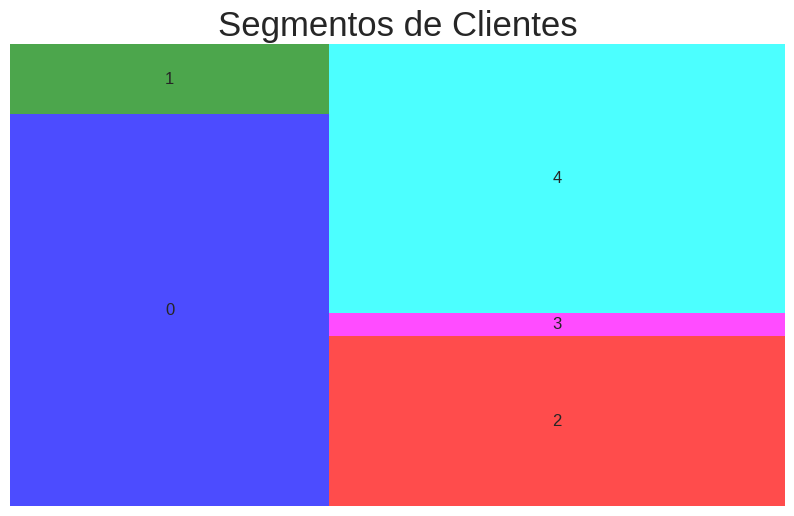

In [37]:
RFM_stats= pd.DataFrame(rfm_clusters_stat(RFM_df4))

# Visualize Segments
plt.figure(figsize=(10, 6))
squarify.plot(sizes=RFM_stats["Monetary"]["count"], label=RFM_stats.index, color=["blue", "green", "red", "magenta", "cyan", "yellow"], alpha=0.7)
plt.title("Segmentos de Clientes", fontsize=25)
plt.axis('off')  # Turn off axis to remove the default axis labels and ticks
plt.show()